# Testing QSP Model

Can we learn the phase angles for a qsp sequence to approximate functions using gradient descent?

We wish to generate optimal QSP/QSVT sequences given constraints, where these constraints follow one of two schema whose character changes the nature of the search problem. 

(1) We may desire a specific quantum response function on a particular subspace. This may be a continuous function $f(x)$ for $-1 \leq x \leq 1$. Although this (tensorflow) model is better suited for learning QSP angles for discrete properties, we can attempt to generate QSP responses that approcimate continuious functions of $x$.


(2) We may desires a specific discrimination behavior against a training set of known form. Refers to a discrete set of input-output behavior.
Example problem: given a finite set of distinct $x_j \in [-1, 1]$, determine the minimal degree real polynomial of bounded norm which has roots $x_j$ and norm bounded by 1. If $W(x)$ has the form of $W(x_j)$ for some known set $x_j$, we can cancel the effect of $W(x_j)$.

For now, we assume a noiseless model.

This notebook implements several examples of using the QSP tensorflow model to learn QSP sequences.

In [7]:
from qsp_models import *
import tensorflow as tf
import numpy as np

# visualization tools
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import scipy
import IPython

sns.set()
plt.rcParams['figure.figsize'] = [10, 5]

## Hamiltonian Simulation

The time evolution of the time-independent hamiltonian $\hat{H}$ is given by $e^{i \hat{H} t}$. If $E_\lambda$ is the energy eigenvalues for eigenstate $|\lambda\rangle$, then

$$ e^{i \hat{H} t} = \sum_\lambda e^{i E_\lambda t} |\lambda\rangle \langle \lambda | =  \sum_\lambda (\cos  E_\lambda t + i \sin E_\lambda t) |\lambda\rangle \langle \lambda |.$$

Thus we desire simulating $p_1(x) = \cos(t x)$ and $p_2(x) = \sin(tx)$ fror some $t$.

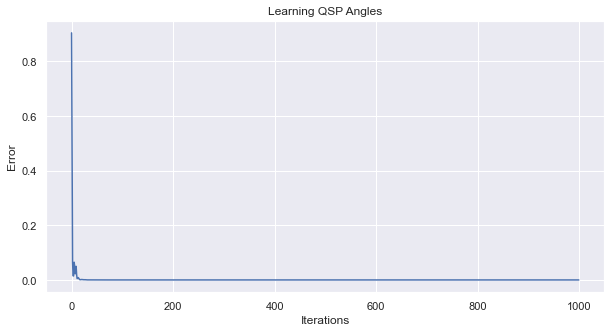

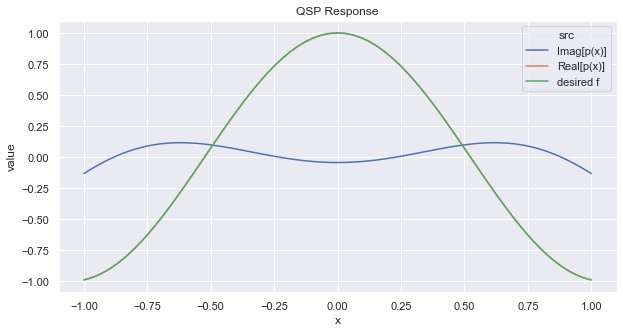

In [23]:
t = 3
poly_deg = 6
f = lambda x: np.cos(t * x)
model = construct_qsp_model(poly_deg)

# The intput theta training values 
th_in = np.arange(0, np.pi, np.pi / 50)
th_in = tf.reshape(th_in, (th_in.shape[0], 1))

# The desired real part of p(x) which is the upper left value in the unitary of the qsp sequence
expected_outputs = f(np.cos(th_in))

model = construct_qsp_model(poly_deg)
history = model.fit(x=th_in, y=expected_outputs, epochs=1000, verbose=0)
plot_loss(history)
plot_qsp_response(f, model)

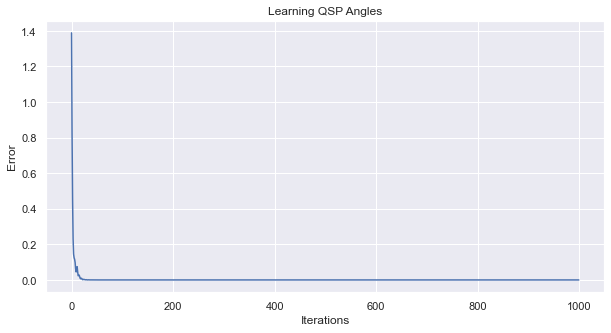

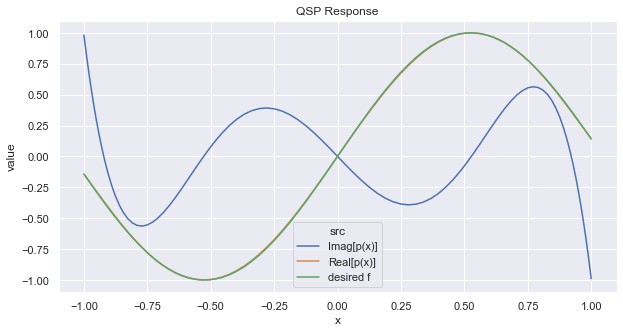

In [24]:
t = 3
poly_deg =5
f = lambda x: np.sin(t * x)
model = construct_qsp_model(poly_deg)

# The intput theta training values 
th_in = np.arange(0, np.pi, np.pi / 50)
th_in = tf.reshape(th_in, (th_in.shape[0], 1))

# The desired real part of p(x) which is the upper left value in the unitary of the qsp sequence
expected_outputs = f(np.cos(th_in))

model = construct_qsp_model(poly_deg)
history = model.fit(x=th_in, y=expected_outputs, epochs=1000, verbose=0)
plot_loss(history)
plot_qsp_response(f, model)

## Moore-Penrose Pseudoinverse

We attempt to approximate a scaled version of the moore-penrose pseudoinverse as given in [this](https://arxiv.org/pdf/1806.01838.pdf) paper (Gilyen et al).

An $\frac{\epsilon}{3}$-approximation of $\frac{\delta}{2x}$ on domain $[-1,1] \setminus (-\frac{\delta}{2},\frac{\delta}{2})$.

Require $0 <   \epsilon \leq \delta \leq \frac{1}{2}$.


See Gilyen 2018 Thm 41.

First prepare the training data:


In [25]:
d = 1/16
e = 1/16
k = 2/d
poly_deg = int((np.log(1/e) / d))
b = np.ceil(k * k * np.log(k/e))
# odd polynomials for now
poly_deg = poly_deg if (np.mod(poly_deg,2) == 1) else (poly_deg + 1)

# approximation to inverse function d/2x
f = lambda x: np.where(x!=0, d / 2 * (1 - (1 - x ** 2) ** b )/ x, 0)

# The intput theta training values 
th_in = np.arange(0, np.pi, np.pi / 30)
th_in = tf.reshape(th_in, (th_in.shape[0], 1))

# The desired real part of p(x) which is the upper left value in the unitary of the qsp sequence
expected_outputs = f(np.cos(th_in))

Plot the training loss and the qsp response:

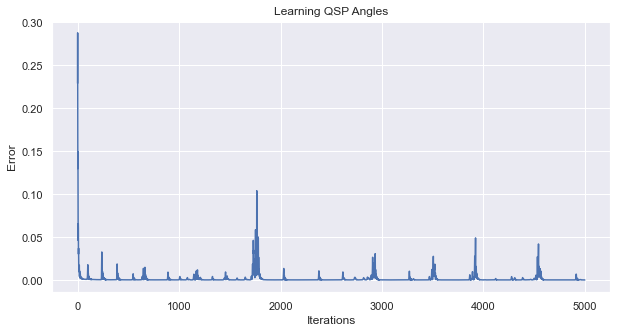

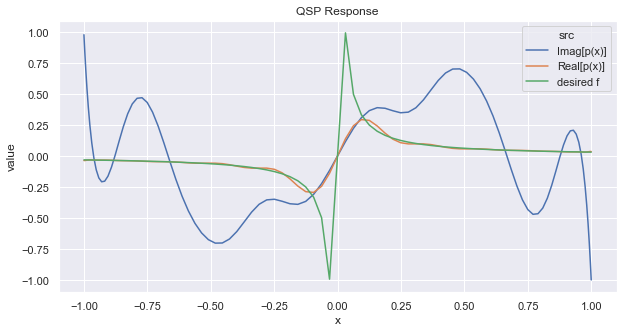

In [26]:
model = construct_qsp_model(poly_deg)
history = model.fit(x=th_in, y=expected_outputs, epochs=5000, verbose=0)
plot_loss(history)
plot_qsp_response(f, model)

## Amplitude Amplification

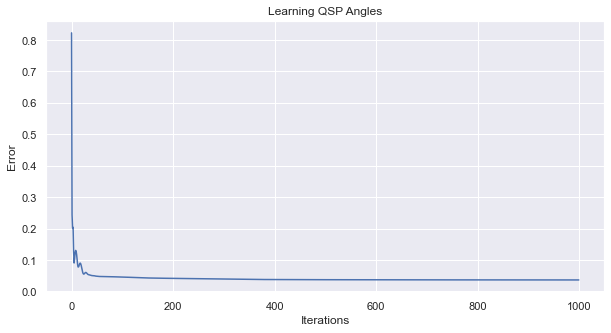

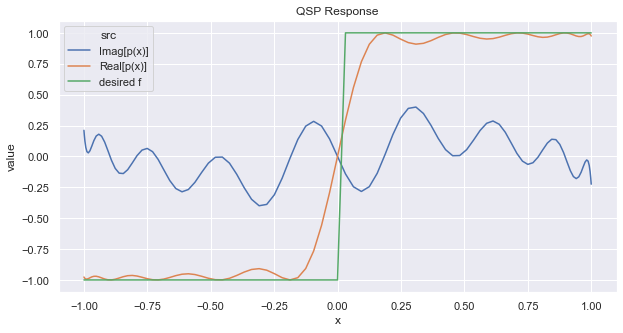

In [20]:
poly_deg = 19
# approximation to inverse function d/2x
f = lambda x: np.where(x<0,-1 ,np.where(x>0,1,0))

# The intput theta training values 
th_in = np.arange(0, np.pi, np.pi / 30)
th_in = tf.reshape(th_in, (th_in.shape[0], 1))

# The desired real part of p(x) which is the upper left value in the unitary of the qsp sequence
expected_outputs = f(np.cos(th_in))

model = construct_qsp_model(poly_deg)
history = model.fit(x=th_in, y=expected_outputs, epochs=1000, verbose=0)
plot_loss(history)
plot_qsp_response(f, model)

## Bandpass Filter

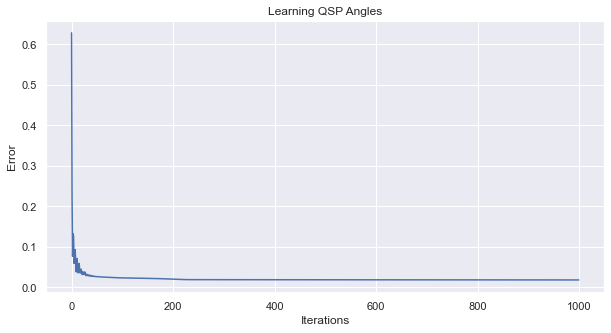

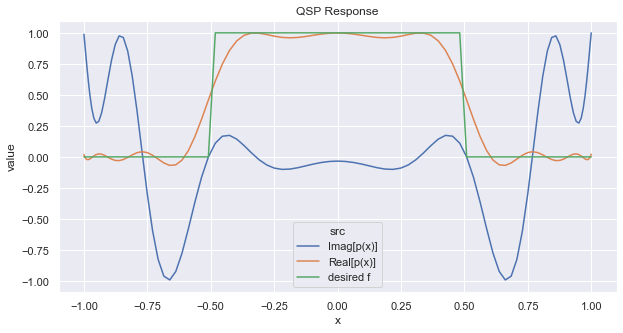

In [8]:
poly_deg = 20
passband = 0.5
# approximation to inverse function d/2x
f = lambda x: np.where(x < -passband, 0, np.where(x > passband, 0, 1))

# The intput theta training values
th_in = np.arange(0, np.pi, np.pi / 30)
th_in = tf.reshape(th_in, (th_in.shape[0], 1))

# The desired real part of p(x) which is the upper left value in the unitary of the qsp sequence
expected_outputs = f(np.cos(th_in))

model = construct_qsp_model(poly_deg)
history = model.fit(x=th_in, y=expected_outputs, epochs=1000, verbose=0)
plot_loss(history)
plot_qsp_response(f, model)